In [88]:
import datetime as dt
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pandas_datareader import data as pdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from lyap import *
from Lyapunov import *

In [89]:
'''The data are composed of eight daily major volatility indexes, mainly, the
VIX (S&P 500 volatility, U.S.), VSTOXX (STOXX 50 volatility, Eurozone),
JNIV (Nikkei 225 volatility, Japan), VFTSE (FTSE 100 volatility, U.K.),
VDAX (DAX 30 volatility, Germany), VCAC (CAC 40 volatility, France),
VAEX (AEX volatility, Netherlands), VSMI (SMI volatility, Switzerland),
from January 1, 2001 until December 15, 2016 collected from Datastream.
Volatility indexes (divided by 100) are the implied standard deviations of
Options on the corresponding market indexes over the next 30 days.'''

'The data are composed of eight daily major volatility indexes, mainly, the\nVIX (S&P 500 volatility, U.S.), VSTOXX (STOXX 50 volatility, Eurozone),\nJNIV (Nikkei 225 volatility, Japan), VFTSE (FTSE 100 volatility, U.K.),\nVDAX (DAX 30 volatility, Germany), VCAC (CAC 40 volatility, France),\nVAEX (AEX volatility, Netherlands), VSMI (SMI volatility, Switzerland),\nfrom January 1, 2001 until December 15, 2016 collected from Datastream.\nVolatility indexes (divided by 100) are the implied standard deviations of\nOptions on the corresponding market indexes over the next 30 days.'

In [90]:
df = pd.read_csv('VIX.csv').loc[251:4265]
df.index = np.arange(len(df))
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,27.930000,30.400000,27.920000,29.990000,29.990000,0
1,2001-01-03,29.629999,29.959999,25.990000,26.600000,26.600000,0
2,2001-01-04,26.350000,27.190001,26.129999,26.969999,26.969999,0
3,2001-01-05,27.809999,29.040001,27.209999,28.670000,28.670000,0
4,2001-01-08,29.980000,30.799999,29.719999,29.840000,29.840000,0
...,...,...,...,...,...,...,...
4010,2016-12-09,12.590000,12.720000,11.670000,11.750000,11.750000,0
4011,2016-12-12,12.230000,12.780000,12.070000,12.640000,12.640000,0
4012,2016-12-13,12.460000,13.420000,12.340000,12.720000,12.720000,0
4013,2016-12-14,12.880000,13.390000,12.480000,13.190000,13.190000,0


In [91]:
#df['Ultimo'] = df['Ultimo'].str.replace(',','.')
#df['Ultimo'] = list(map(float, df['Ultimo']))

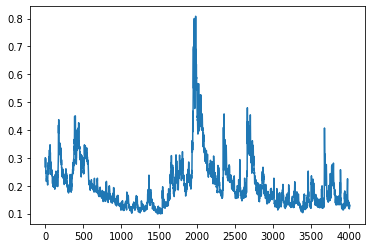

In [92]:
df['Close'] = df['Close']/100
close = df['Close']
plt.plot(close)

In [93]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.0
mean,20.361858,21.151357,19.517935,0.202263,20.226301,0.0
std,8.973546,9.471873,8.418720,0.089144,8.914352,0.0
min,9.680000,10.060000,9.390000,0.098900,9.890000,0.0
25%,14.045000,14.630000,13.570000,0.139800,13.980000,0.0
50%,17.900000,18.580000,17.139999,0.177900,17.790001,0.0
75%,23.695001,24.575000,22.765000,0.236350,23.635001,0.0
max,80.739998,89.529999,72.760002,0.808600,80.860001,0.0


In [94]:
# Dimensionality parameters
L = 1   # step granularity
m = 4  # window size
q = 2  # number of neurons

In [95]:
def sliding_window(df, m, L): 
    slid_w = []
    targets = []
    for i,row in df.iterrows():
        if i + m*L < len(df.index):
            slid_w.append(list(df.loc[i:i+L*m-1:L,'Close']))
            targets.append(df.loc[i+m*L,'Close'])
    data = pd.DataFrame(slid_w)
    return data,targets

X, y = sliding_window(df, m, L)
y = pd.DataFrame(y, columns = ['target'])

In [96]:
scaler = StandardScaler()
scaler.fit(pd.concat([X, y]))
X = pd.DataFrame(scaler.transform(pd.concat([X, y], axis = 1)))

In [97]:
y = X.loc[:,m]
X = X.loc[:,:(m-1)]

In [98]:
model = Sequential([
  Dense(q, activation='tanh', input_shape=(m,)),
  Dense(1),
])

model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['mse','mae'],
)

model.fit(X, np.asarray(y), epochs=20, verbose = False, batch_size = 16)
model.evaluate(X, np.asarray(y))

4011/4011 [==============================] - 0s 51us/sample - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1383


[0.05707098841314243, 0.05707098, 0.13826136]

In [99]:
y_predict = pd.DataFrame(model.predict(X).reshape(1,-1)).T
y_predict.columns = ['target']
new_X = pd.concat([X, y_predict], axis = 1)
new_X = pd.DataFrame(scaler.inverse_transform(new_X))
new_y = new_X[m]

In [100]:
new_y

0       0.291227
1       0.300871
2       0.277470
3       0.264097
4       0.255710
          ...   
4006    0.133722
4007    0.127405
4008    0.133272
4009    0.134606
4010    0.137026
Name: 4, Length: 4011, dtype: float64

In [101]:
new_close = close[m:]
new_close.index = range(len(new_close))

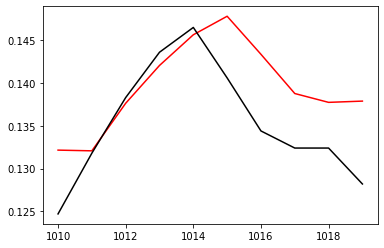

In [102]:
plt.plot(new_y[1010:1020],c = 'red')
plt.plot(new_close[1010:1020], c = 'black')

In [103]:
alpha_0 = model.layers[1].get_weights()[1]
alpha_1 = model.layers[1].get_weights()[0]
beta_0 = model.layers[0].get_weights()[1]
beta_1 = np.asmatrix(model.layers[1].get_weights()[1])

In [132]:
T=160
a=model.layers[1].get_weights()[0]
b=model.layers[0].get_weights()[0]
bi=model.layers[0].get_weights()[1]
l=Jacobian(a, b, bi, close,L,m,q,100)
print(l)

TypeError: float() argument must be a string or a number, not 'Tensor'

array([[ 0.02135967, -0.02595076, -0.00658617,  0.28909543],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

ValueError: could not broadcast input array from shape (8) into shape (4)

100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31


numpy.float64